In [2]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils as utils, util as wavelet
from saveCore_standalone_v3 import run_powerBlobs as run_powerBlobsN, powerBlob_utils as utilsN, util as waveletN
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [83]:
idate = '20200906'
time = 0
#tag = 'MFG'
tag = 'MSG'
testfile = '/media/ck/Elements/Africa/WestAfrica/NFLICS/MCS_TIR/real_time_wavelet/'+idate[0:4]+'/'+idate[4:6]+'/'+idate[6:8]+'/IR_wavelet_BT_'+idate+'_*.nc'
origfile = '/media/ck/Elements/Africa/WestAfrica/NFLICS/MCS_TIR/real_time_data/'+idate[0:4]+'/'+idate[4:6]+'/'+idate[6:8]+'/IR_108_BT_'+idate+'_*.nc'

In [84]:
data = xr.open_mfdataset(testfile)#.sel(lat=slice(6,8), lon=slice(6,9.5))'/media/ck/Elements/Africa/WestAfrica/NFLICS/MCS_TIR/real_time_wavelet/2020/06/25/IR_wavelet_BT_20200625_1300.nc'

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [85]:
data

<xarray.Dataset>
Dimensions:  (lat: 566, lon: 667, time: 95)
Coordinates:
  * lat      (lat) float64 4.0 4.027 4.054 4.081 ... 18.89 18.92 18.95 18.97
  * lon      (lon) float64 -19.0 -18.97 -18.95 -18.92 ... -1.106 -1.079 -1.052
  * time     (time) datetime64[ns] 2020-09-06 ... 2020-09-06T23:45:00
Data variables:
    power    (time, lat, lon) float64 dask.array<chunksize=(1, 566, 667), meta=np.ndarray>
    BT       (time, lat, lon) int16 dask.array<chunksize=(1, 566, 667), meta=np.ndarray>
Attributes:
    radii:              [ 2  3  4  6 10 16 24]
    scales_rounded:     [ 12  18  28  42  63  96 146]
    scales_original:    [ 12.          18.1885988   27.56876052  41.78642704 ...
    cutout_T:           -40
    cutout_minPixelNb:  78.53981633974483

In [86]:
tstep_old = data.isel(time=time).load() #-24

In [87]:
tstep_old

<xarray.Dataset>
Dimensions:  (lat: 566, lon: 667)
Coordinates:
  * lat      (lat) float64 4.0 4.027 4.054 4.081 ... 18.89 18.92 18.95 18.97
  * lon      (lon) float64 -19.0 -18.97 -18.95 -18.92 ... -1.106 -1.079 -1.052
    time     datetime64[ns] 2020-09-06
Data variables:
    power    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    BT       (lat, lon) int16 1882 1771 1781 1985 1973 ... 2150 2190 2208 2220
Attributes:
    radii:              [ 2  3  4  6 10 16 24]
    scales_rounded:     [ 12  18  28  42  63  96 146]
    scales_original:    [ 12.          18.1885988   27.56876052  41.78642704 ...
    cutout_T:           -40
    cutout_minPixelNb:  78.53981633974483

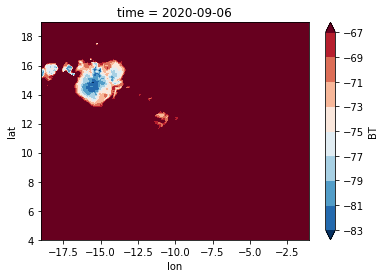

In [88]:
(tstep_old['BT']/100).plot.contourf(levels=np.arange(-83,-65,2))

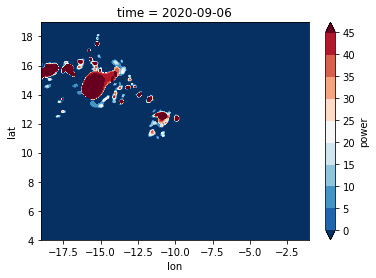

In [89]:
tstep_old['power'].plot.contourf(levels=np.arange(0,50,5))

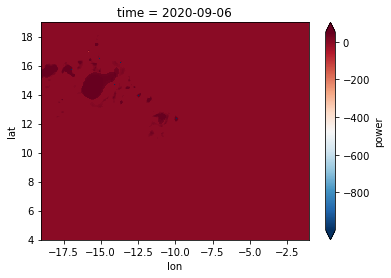

In [90]:
tstep_old['power'].plot.pcolormesh(vmin=-999, vmax=50, cmap='RdBu_r')

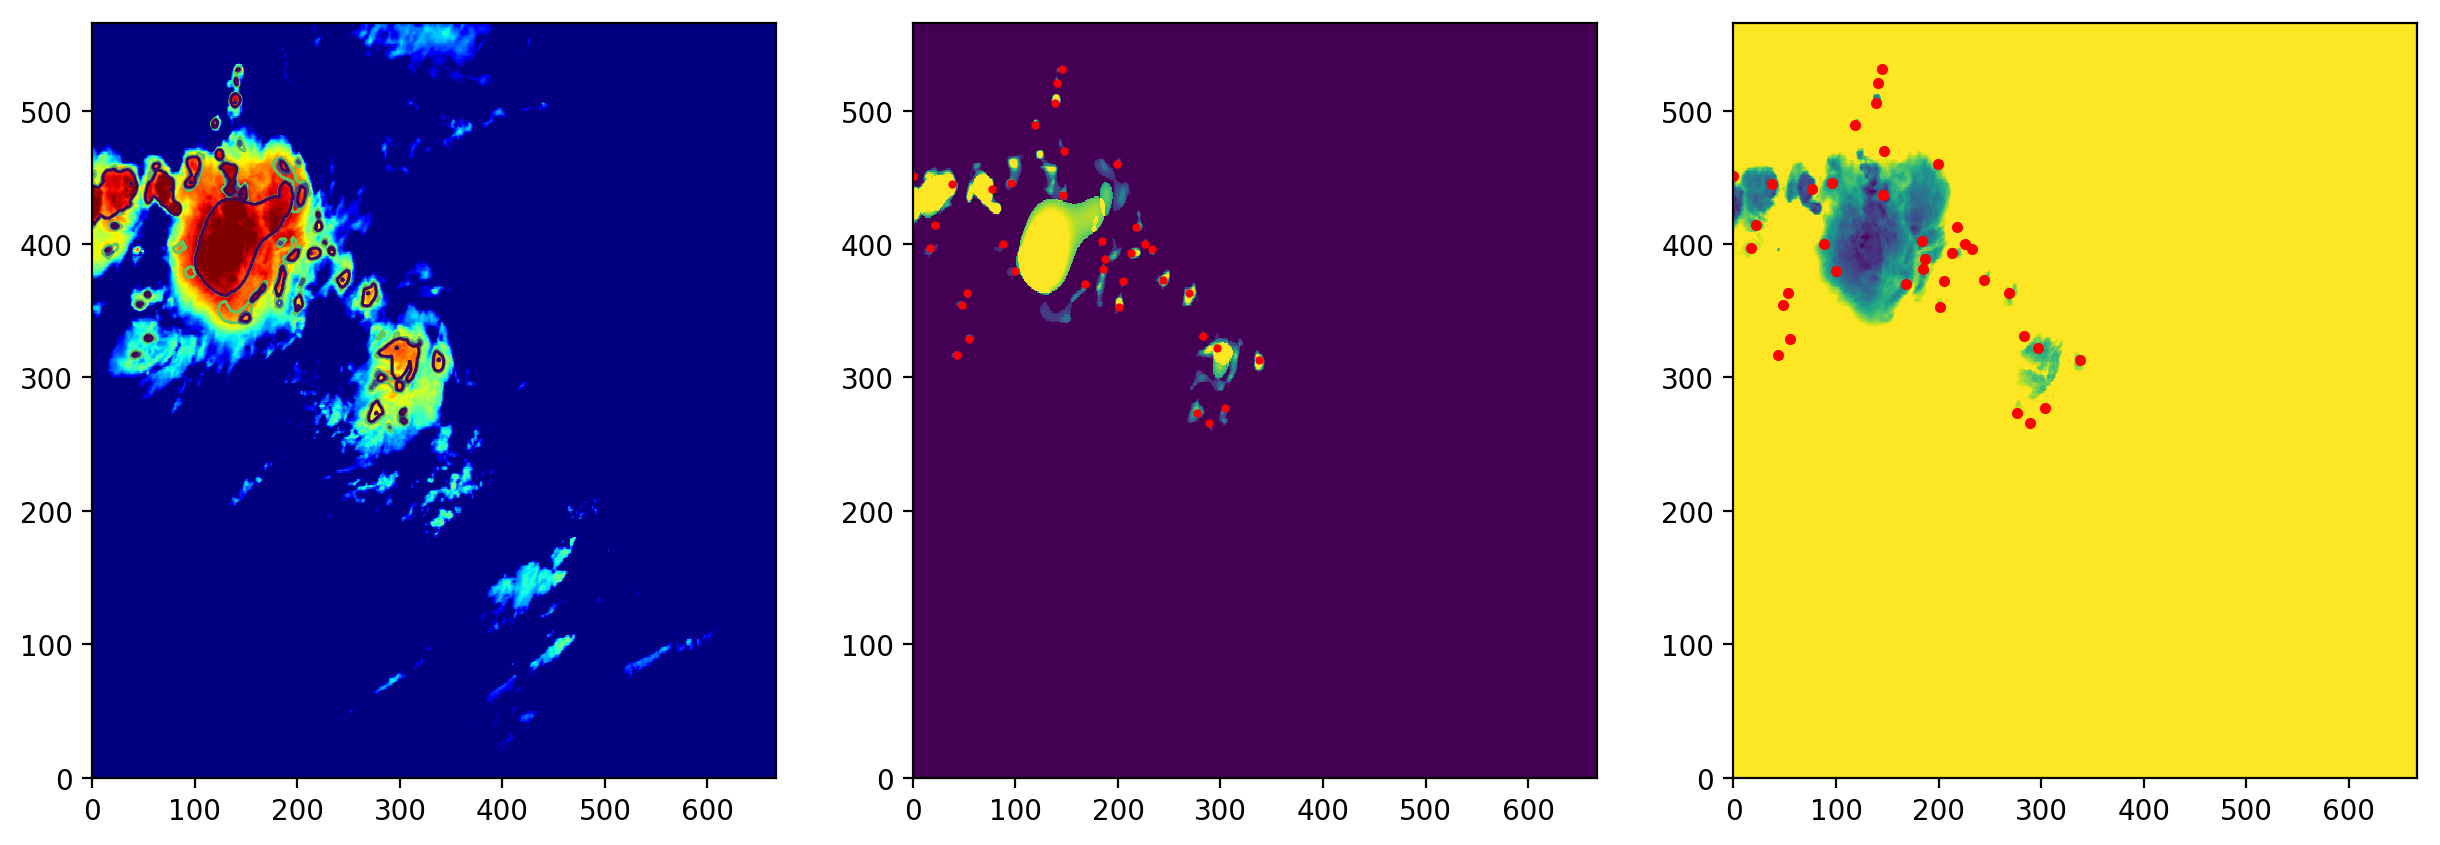

In [91]:
lon, lat = np.meshgrid(tstep_old['lon'], tstep_old['lat'])

f = plt.figure(figsize=(15,5), dpi=200)
f.add_subplot(131)
plt.pcolormesh(tstep_old['BT']/100, vmin=-80, vmax=-40, cmap='jet_r')
plt.contour(tstep_old['power'], levels=[-5,0,10,15], extend='both', linewidths=1, cmap='viridis_r')

npos = np.where(tstep_old['power']<-100)

f.add_subplot(132)
plt.pcolormesh(tstep_old['power'], vmin=0, vmax=50)
    
for y,x in zip(npos[0], npos[1]):
    

    plt.plot(x,y, color='red', markersize=2, marker='o')

    
f.add_subplot(133)
plt.pcolormesh(tstep_old['BT']/100, vmax=-65, vmin=-85)
for y,x in zip(npos[0], npos[1]):
    
    plt.plot(x,y, color='red', markersize=3, marker='o')
    

#f.savefig('/home/ck/DIR/cornkle/data/test/old_cores'+tag+'.png')


In [92]:
#tstep_old = xr.open_mfdataset(origfile, decode_times=False)
meteosat_data = tstep_old['BT'].values/100
latitudes = tstep_old.lat
longitudes = tstep_old.lon
date = tstep_old.time


In [138]:
from utils import u_grid, u_interpolate as u_int
import glob

met_folder = '/media/ck/Elements/Africa/WestAfrica/NFLICS/MCS_TIR/real_time_data/2020/09/06/'

files = glob.glob(met_folder + 'IR_108_BT_20200906_0000.nc')

ds = xr.open_dataset(files[0], decode_times=False)


In [139]:
files

['/media/ck/Elements/Africa/WestAfrica/NFLICS/MCS_TIR/real_time_data/2020/09/06/IR_108_BT_20200906_0000.nc']

In [170]:
#ds = ds.isel(time=time).load() #-24

data_resolution = 3 # in km
# make salem grid
grid = u_grid.make(np.arange(-19,0), np.arange(4,20), data_resolution*1000)
dlon = ds['lon_2d'].squeeze().values.T
dlat = ds['lat_2d'].squeeze().values.T
inds, weights, shape = u_int.interpolation_weights_grid(dlon, dlat, grid)

data = ds['IR108_BT'].squeeze().values.T
try:
    outt = u_int.interpolate_data(data, inds, weights, shape)
except IndexError:
    print('Interpolation problem, continue')
lonN, latN = grid.ll_coordinates

In [171]:
savefile = '/home/ck/DIR/cornkle/data/test/testblob.nc'
nflics = run_powerBlobsN.wavelet_analysis(outt, lonN, latN, date, savefile, data_resolution=3)

outmin -87.6425906327473 24.2120361328125
Saved /home/ck/DIR/cornkle/data/test/testblob.nc


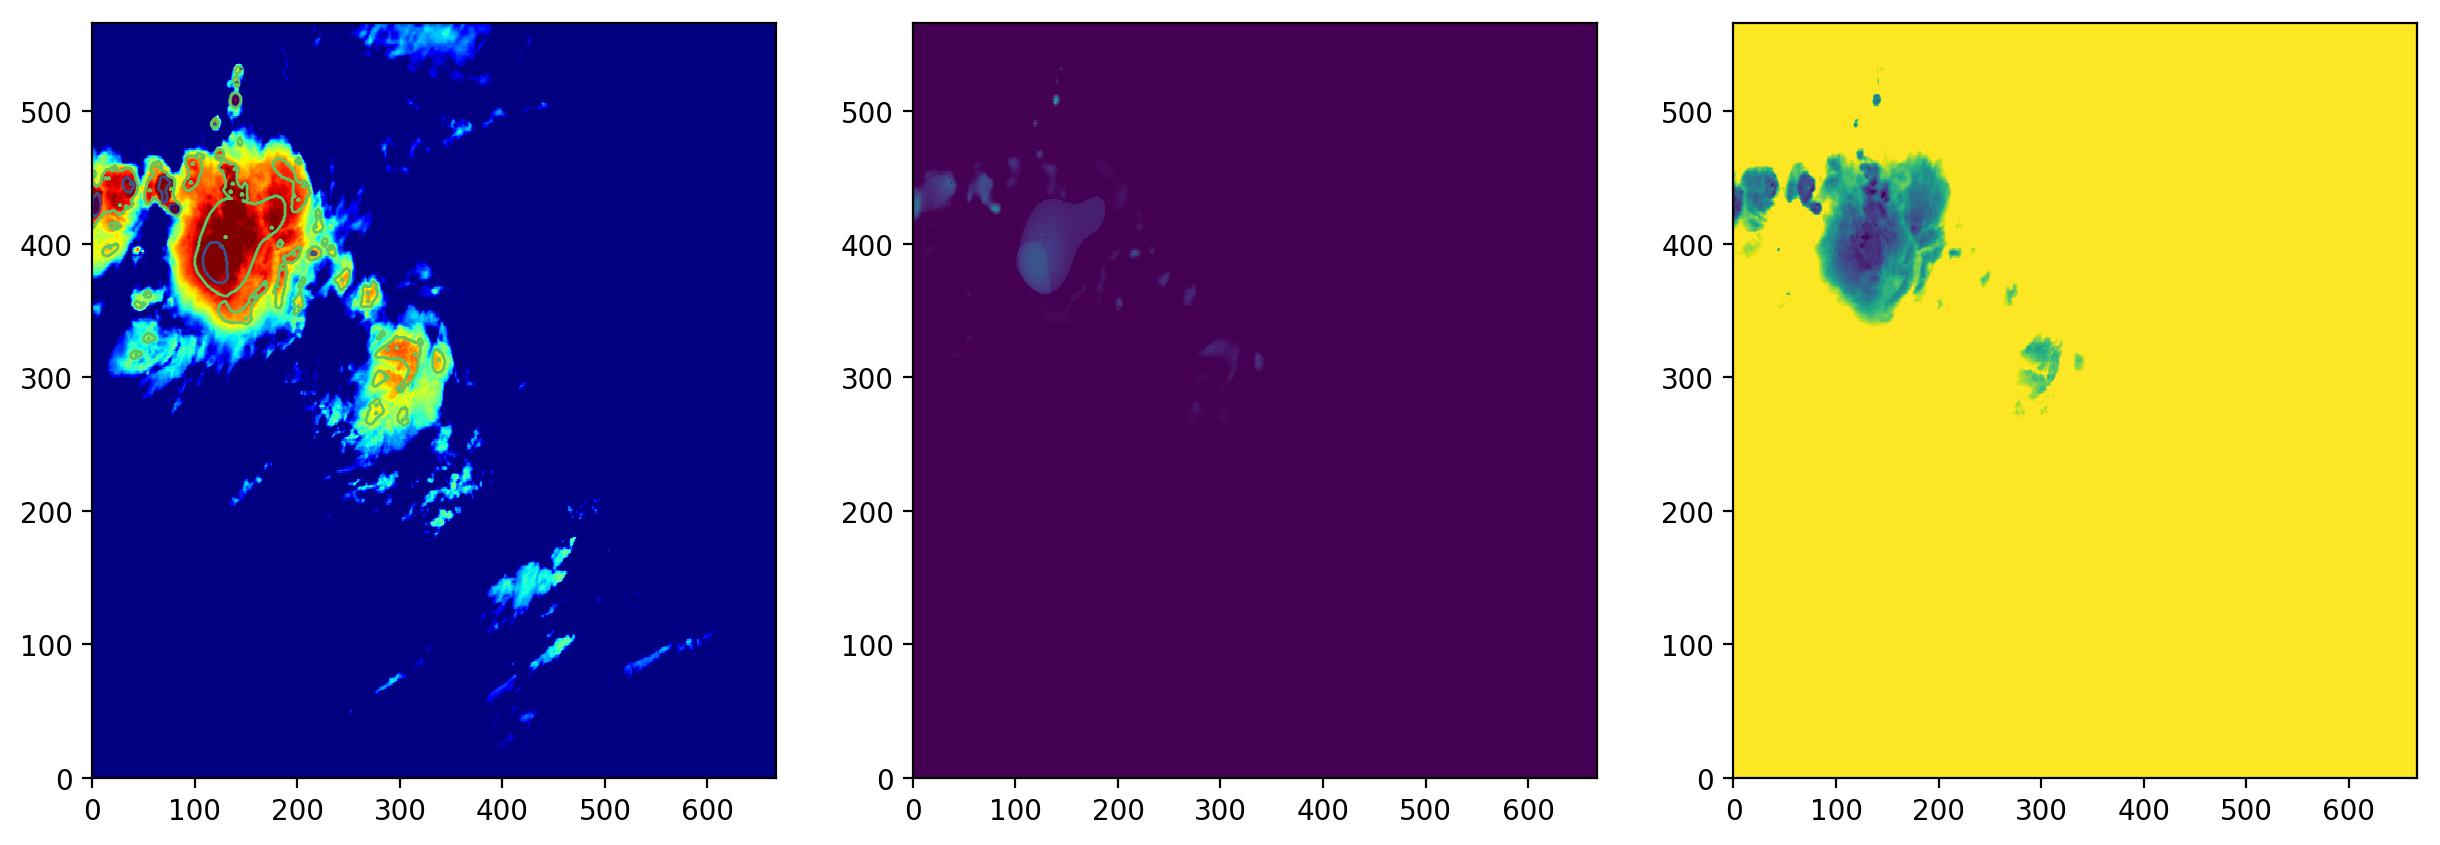

In [189]:
lon, lat = np.meshgrid(nflics['lon'], nflics['lat'])

f = plt.figure(figsize=(15,5), dpi=200)
f.add_subplot(131)
plt.pcolormesh(nflics['BT']/100, vmin=-80, vmax=-40, cmap='jet_r')
plt.contour(nflics['power'].sum(axis=0)/1000, levels=[-5,0,10,15], extend='both', linewidths=1, cmap='viridis_r')

npos = np.where(np.sum(nflics['power']<0,axis=0) < 0)

f.add_subplot(132)
plt.pcolormesh(nflics['power'].sum(axis=0)/1000, vmin=0, vmax=50)
    
for y,x in zip(npos[0], npos[1]):
    

    plt.plot(x,y, color='red', markersize=2, marker='o')

    
f.add_subplot(133)
plt.pcolormesh(nflics['BT']/100, vmax=-65, vmin=-85)
for y,x in zip(npos[0], npos[1]):
    
    plt.plot(x,y, color='red', markersize=3, marker='o')
    

#f.savefig('/home/ck/DIR/cornkle/data/test/old_cores'+tag+'.png')

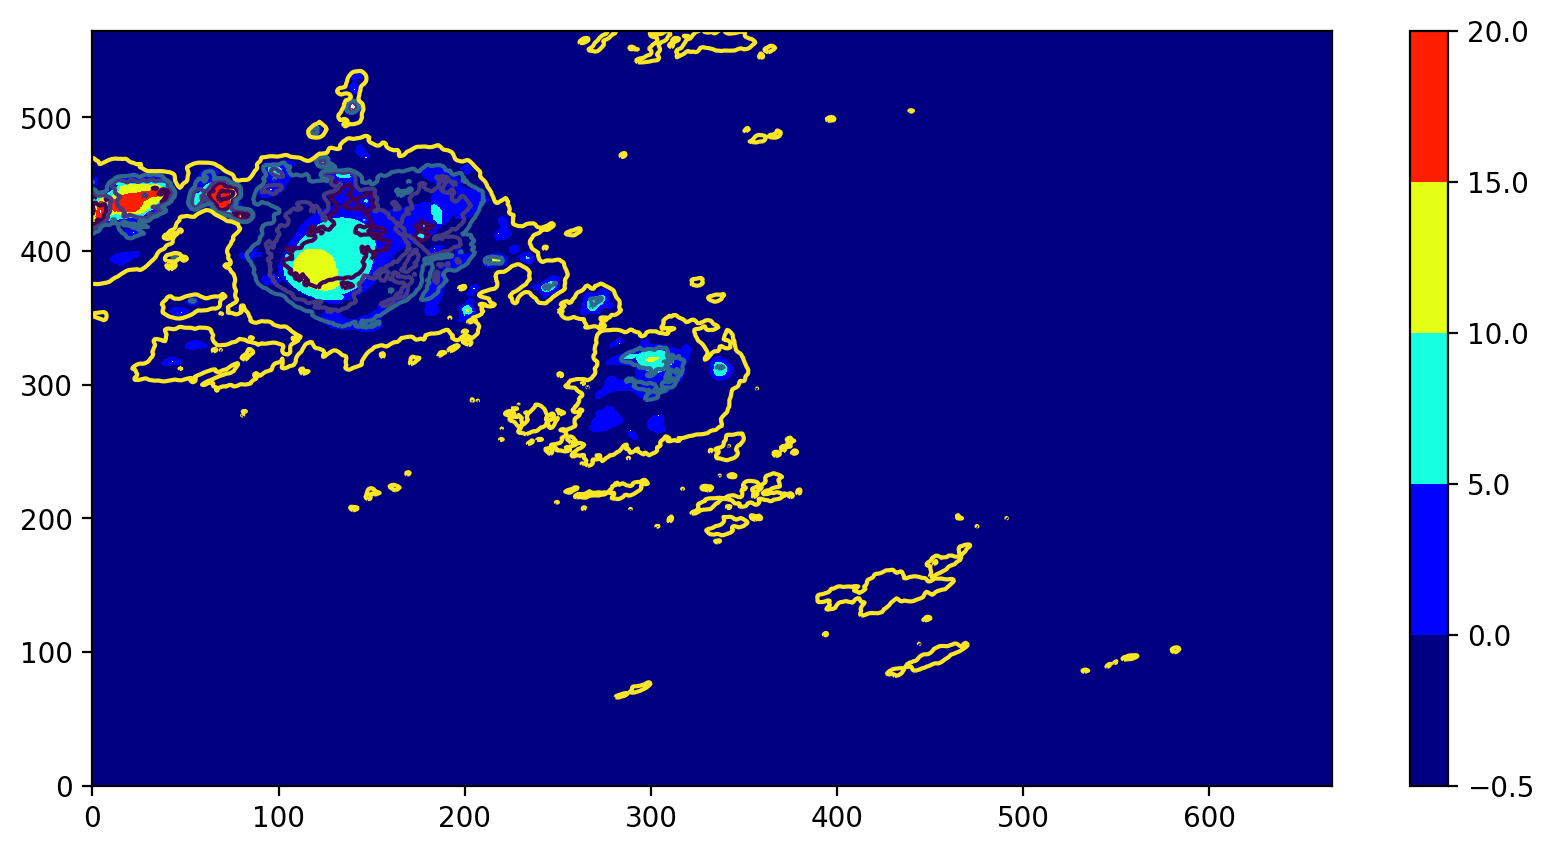

In [183]:
plt.figure(figsize=(10,5), dpi=200)
plt.contourf(tstep_old['power']/10, vmin=0, cmap='jet', levels=[-0.5,0,5,10,15, 20])
plt.colorbar()
plt.contour(tstep_old['BT']/100, levels=[-80,-75,-70,-50])

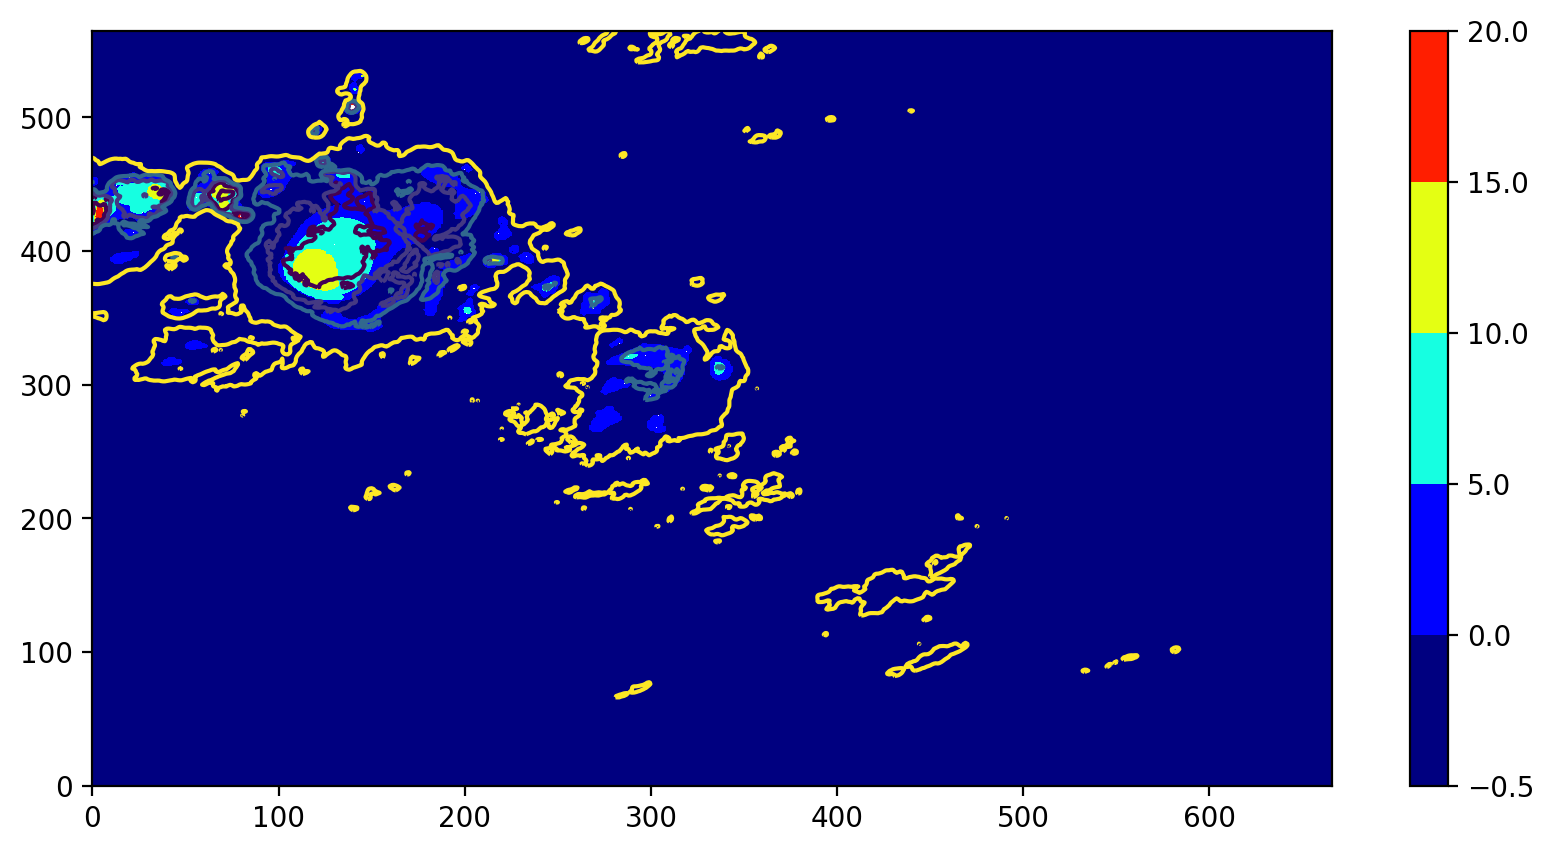

In [182]:
plt.figure(figsize=(10,5), dpi=200)
plt.contourf(nflics['power'].sum(axis=0)/1000, vmin=0, cmap='jet', levels=[-0.5,0,5,10,15,20])
plt.colorbar()
plt.contour(nflics['BT']/100, levels=[-80,-75,-70,-50])

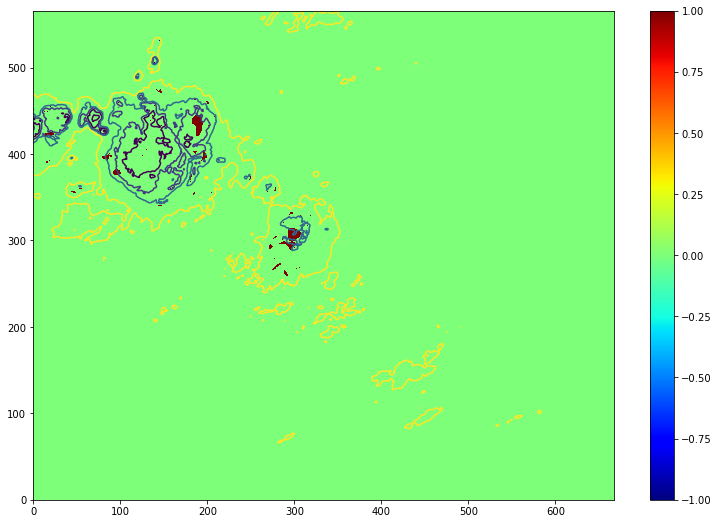

In [184]:
old_mask = np.array(tstep_old['power'].values > 0, dtype=int)
new_mask = np.array(nflics['power'].sum(axis=0).values > 0, dtype=int)
plt.figure(figsize=(13,9))
plt.pcolormesh(old_mask-new_mask, vmin=-1, vmax=1, cmap='jet')

plt.colorbar()
plt.contour(nflics['BT']/100, levels=[-80,-75,-70,-50])